In [7]:
import matplotlib.pyplot as p
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from pyspikelib import TrainNormalizeTransform
from pyspikelib import TsfreshVectorizeTransform
from pyspikelib import TsfreshFeaturePreprocessorPipeline
from pyspikelib.utils import simple_undersampling
import pyspikelib.mpladeq as mpladeq

from dataset_adapters import fcx1_dataset

from pathlib import Path

mpladeq.beautify_mpl()

import warnings
warnings.filterwarnings('ignore')

In [3]:
! ls ../data/

allen		       fcx1_data.tar  retina	  sleep.parq.gz  wake.parq.gz
data_download_link.md  README.md      sleep.parq  wake.parq


In [4]:
! cd ../data; tar -xvf ../data/fcx1_data.tar ./

./README.md
./sleep.parq.gz
./wake.parq.gz


In [9]:
! gzip -df ../data/sleep.parq.gz; gzip -df ../data/wake.parq.gz 

In [4]:
datapath = Path('../data/')
wake_spikes = fcx1_dataset(datapath / 'wake.parq')
sleep_spikes = fcx1_dataset(datapath / 'sleep.parq')

In [5]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.7)
X = np.hstack([wake_spikes.series.values, sleep_spikes.series.values])
y = np.hstack([np.ones(wake_spikes.shape[0]), np.zeros(sleep_spikes.shape[0])])
groups = np.hstack([wake_spikes.groups.values, sleep_spikes.groups.values])

for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

Text(0, 0.5, 'ISI value, ms')

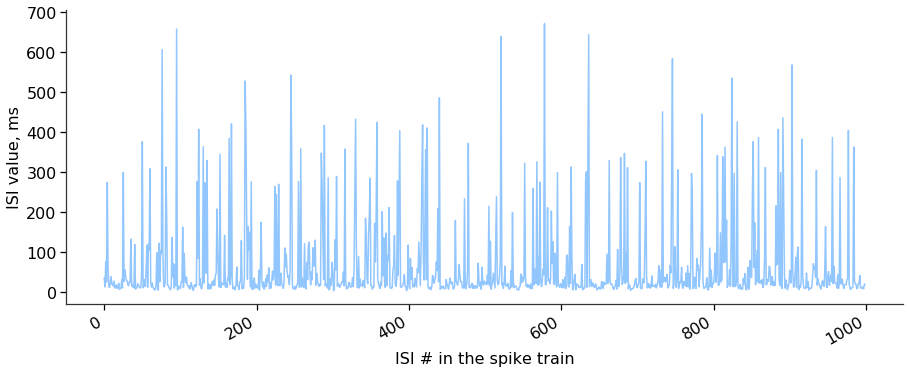

In [10]:
string_to_float = lambda string: [float(value) for value in string.split(',')]
train = string_to_float(X_train.series.values[42])

p.plot(train[:1000])
mpladeq.prettify((15, 6))
p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

In [11]:
def prepare_tsfresh_data(X, y):
    """Extract and preprocess tsfresh features from spiking data"""
    normalizer = TrainNormalizeTransform(window=200, step=200)
    X, y = normalizer.transform(X, y, delimiter=',')
    vectorizer = TsfreshVectorizeTransform(feature_set=None)
    X = vectorizer.transform(X)
    return X, y

In [12]:
X_train_full, y_train = prepare_tsfresh_data(X_train, y_train)
X_test_full, y_test = prepare_tsfresh_data(X_test, y_test)

Feature Extraction: 100%|██████████| 159/159 [04:26<00:00,  3.07it/s]


In [21]:
preprocessing = TsfreshFeaturePreprocessorPipeline(
    do_scaling=True, remove_low_variance=True
).construct_pipeline()

preprocessing.fit(X_train_full)
X_train = preprocessing.transform(X_train_full)
X_test = preprocessing.transform(X_test_full)

In [22]:
print('Target mean | train: {} test: {}'.format(y_train.mean(), y_test.mean()))
print('Dataset shape | train: {} test: {}'.format(X_train.shape, X_test.shape))

Target mean | train: 0.328680479825518 test: 0.3739492558031927
Dataset shape | train: (4585, 684) test: (12967, 684)


In [23]:
def random_forest_scores(X_train, X_test, y_train, y_test, train_subsample_size=5000, test_subsample_size=5000):
    X_train, y_train = simple_undersampling(X_train, y_train, subsample_size=train_subsample_size)
    X_test, y_test = simple_undersampling(X_test, y_test, subsample_size=test_subsample_size)
    forest = RandomForestClassifier(n_estimators=200, random_state=41, n_jobs=-1)
    forest.fit(X_train, y_train)
    acc_score = accuracy_score(y_test, forest.predict(X_test))
    auc_roc_score = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
    print('Accuracy & AUC-ROC scores of RF: {}, {}'.format(acc_score, auc_roc_score))
    importance = pd.DataFrame({'feature': X_train.columns.values,
                               'importance': forest.feature_importances_})
    return {'accuracy': acc_score, 'auc-roc': auc_roc_score}, importance

In [24]:
trials = 10
for trial in range(trials):
    scores, importance = random_forest_scores(X_train, X_test, y_train, y_test, 
                                              train_subsample_size=4500, test_subsample_size=10000)

Accuracy & AUC-ROC scores of RF: 0.7325, 0.8284490684701663
Accuracy & AUC-ROC scores of RF: 0.7131, 0.8156834512575284
Accuracy & AUC-ROC scores of RF: 0.7085, 0.8134648312003303
Accuracy & AUC-ROC scores of RF: 0.731, 0.824109119010176
Accuracy & AUC-ROC scores of RF: 0.7197, 0.8209569057925062
Accuracy & AUC-ROC scores of RF: 0.7216, 0.8231713429699599
Accuracy & AUC-ROC scores of RF: 0.7179, 0.8218822828985966
Accuracy & AUC-ROC scores of RF: 0.712, 0.8199941799476195
Accuracy & AUC-ROC scores of RF: 0.7192, 0.8204669810813197
Accuracy & AUC-ROC scores of RF: 0.7258, 0.8229362268669631


In [25]:
importance.head(20)

,feature,importance
0,value__abs_energy,0.002440
1,value__absolute_sum_of_changes,0.002638
2,"value__agg_autocorrelation__f_agg_""mean""__maxl...",0.001237
3,"value__agg_autocorrelation__f_agg_""median""__ma...",0.001259
4,"value__agg_autocorrelation__f_agg_""var""__maxla...",0.001368
5,"value__agg_linear_trend__f_agg_""max""__chunk_le...",0.002696
6,"value__agg_linear_trend__f_agg_""max""__chunk_le...",0.000708
7,"value__agg_linear_trend__f_agg_""max""__chunk_le...",0.001024
8,"value__agg_linear_trend__f_agg_""max""__chunk_le...",0.002506
9,"value__agg_linear_trend__f_agg_""max""__chunk_le...",0.002734


In [26]:
feature_names = [
    'abs_energy',
    'mean',
    'median',
    'minimum',
    'maximum',
    'standard_deviation',
]
simple_baseline_features = ['value__' + name for name in feature_names]
X_train = X_train.loc[:, simple_baseline_features]
X_test = X_test.loc[:, simple_baseline_features]

In [28]:
trials = 10
for trial in range(trials):
    random_forest_scores(X_train, X_test, y_train, y_test, 
                         train_subsample_size=4500, test_subsample_size=10000)

Accuracy & AUC-ROC scores of RF: 0.6739, 0.7533925192519252
Accuracy & AUC-ROC scores of RF: 0.6804, 0.7589438714887352
Accuracy & AUC-ROC scores of RF: 0.6703, 0.7512817832813652
Accuracy & AUC-ROC scores of RF: 0.6857, 0.7595317709563466
Accuracy & AUC-ROC scores of RF: 0.6809, 0.7577045321115979
Accuracy & AUC-ROC scores of RF: 0.6851, 0.7605907850375984
Accuracy & AUC-ROC scores of RF: 0.6849, 0.7674596018863954
Accuracy & AUC-ROC scores of RF: 0.6846, 0.7616921066578591
Accuracy & AUC-ROC scores of RF: 0.6816, 0.7635590569449111
Accuracy & AUC-ROC scores of RF: 0.6864, 0.7712238410145691
